# Interpretable Deep Learning: ANNs for Tabular Data with PyTorch & SHAP

This notebook is designed for your project to demonstrate how Deep Learning (ANN) models make predictions on tabular data using **PyTorch**.

It's broken into two main modules:

1.  **Module 1: Regression**
2.  **Module 2: Classification**

Each module will:
* Load a sample dataset (simulating your 'cleaned' data).
* Process the data (scaling, splitting).
* Convert data to PyTorch Tensors.
* Define, train, and evaluate two different custom PyTorch ANN architectures.
* **Visualize the model architecture** using `torchviz` (for all four models).
* **Generate and visualize model interpretations** using `shap.DeepExplainer`.

### 1. Initial Setup and Imports

First, let's install and import all the necessary libraries.

In [1]:
%pip install torch scikit-learn pandas numpy shap torchviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# SHAP Imports
import shap

# Torchviz Import
from torchviz import make_dot

# This is crucial for SHAP plots to render in the notebook
shap.initjs()

---

## MODULE 1: REGRESSION

### 1.1: Load and Prepare Regression Data


In [3]:
# Load sample data
housing = fetch_california_housing()
data_reg = pd.DataFrame(housing.data, columns=housing.feature_names)
data_reg['Target'] = housing.target

print("Regression Data Head:")
display(data_reg.head())

Regression Data Head:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 1.2: Data Processing (Regression)

This step is identical: split and **scale** the data. Scaling is critical for ANNs.

In [4]:
# 1. Define Target and Features
TARGET_COLUMN_REG = 'Target'
features_reg = [col for col in data_reg.columns if col != TARGET_COLUMN_REG]

X_reg = data_reg[features_reg]
y_reg = data_reg[TARGET_COLUMN_REG]

# 2. Train-Test Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 3. Scale the data (CRITICAL step for ANNs)
scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(X_train_reg)
X_test_scaled_reg = scaler_reg.transform(X_test_reg)

print(f"Training data shape: {X_train_scaled_reg.shape}")
print(f"Test data shape: {X_test_scaled_reg.shape}")

Training data shape: (16512, 8)
Test data shape: (4128, 8)


### 1.3: Convert Data to PyTorch Tensors

PyTorch models require `torch.Tensor` objects as input. We also use `TensorDataset` and `DataLoader` to easily manage batches during training.

In [5]:
# Convert numpy arrays to PyTorch tensors
X_train_t_reg = torch.tensor(X_train_scaled_reg, dtype=torch.float32)
# Reshape y to be [n_samples, 1] which is expected by the loss function
y_train_t_reg = torch.tensor(y_train_reg.values, dtype=torch.float32).view(-1, 1)

X_test_t_reg = torch.tensor(X_test_scaled_reg, dtype=torch.float32)
y_test_t_reg = torch.tensor(y_test_reg.values, dtype=torch.float32).view(-1, 1)

# Create TensorDataset and DataLoader
train_dataset_reg = TensorDataset(X_train_t_reg, y_train_t_reg)
train_loader_reg = DataLoader(train_dataset_reg, batch_size=32, shuffle=True)

print(f"Train tensor X shape: {X_train_t_reg.shape}")
print(f"Train tensor y shape: {y_train_t_reg.shape}")

Train tensor X shape: torch.Size([16512, 8])
Train tensor y shape: torch.Size([16512, 1])


### 1.4: Regression ANN - Model 1 (Simple Architecture)

In PyTorch, we define models by creating a class that inherits from `nn.Module`.

In [6]:
class RegressionModel1(nn.Module):
    def __init__(self, input_shape):
        super(RegressionModel1, self).__init__()
        self.layer1 = nn.Linear(input_shape, 64)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(32, 1) # No activation for regression output

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.output(x)
        return x

# Instantiate the model
input_shape_reg = X_train_t_reg.shape[1]
model1_reg = RegressionModel1(input_shape_reg)
print(model1_reg)

RegressionModel1(
  (layer1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
)


### 1.5: Visualize Regression Model 1 Architecture

We use `torchviz` to show the computation graph of the model.

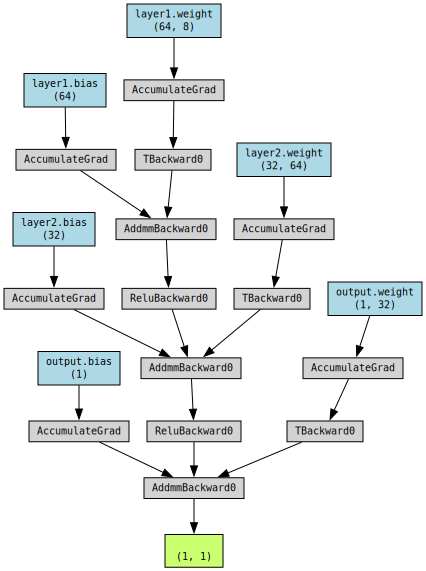

In [7]:
# To visualize the model, we pass a sample input tensor
# We use one sample from the training data
sample_input_reg = X_train_t_reg[0].unsqueeze(0) 

# Generate the graph
dot1 = make_dot(model1_reg(sample_input_reg), params=dict(model1_reg.named_parameters()))

# Display the graph in the notebook
display(dot1)

### 1.6: Training Loop (Model 1)

In [8]:
# Define loss function and optimizer
criterion_reg = nn.MSELoss()  # Mean Squared Error for regression
optimizer_reg1 = optim.Adam(model1_reg.parameters(), lr=0.001)

epochs = 50
print("Training Regression Model 1...")

for epoch in range(epochs):
    # Set model to training mode
    model1_reg.train()
    for inputs, labels in train_loader_reg:
        # 1. Forward pass
        outputs = model1_reg(inputs)
        loss = criterion_reg(outputs, labels)
        
        # 2. Backward pass and optimization
        optimizer_reg1.zero_grad() # Clear old gradients
        loss.backward()          # Calculate new gradients
        optimizer_reg1.step()      # Update weights
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

Training Regression Model 1...
Epoch [10/50], Loss: 0.6142
Epoch [20/50], Loss: 0.1642
Epoch [30/50], Loss: 0.3242
Epoch [40/50], Loss: 0.2074
Epoch [50/50], Loss: 0.2147
Training complete.


### 1.7: Evaluation (Model 1)

We use `model.eval()` to turn off training-specific layers (like Dropout) and `torch.no_grad()` to save memory.

In [9]:
print("Evaluating Model 1...")
model1_reg.eval()  # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    y_pred_reg1 = model1_reg(X_test_t_reg)
    
    # Convert back to numpy for sklearn metrics
    mse = mean_squared_error(y_test_t_reg.numpy(), y_pred_reg1.numpy())
    print(f"Model 1 Test MSE: {mse:.4f}")

Evaluating Model 1...
Model 1 Test MSE: 0.2896


### 1.8: Regression ANN - Model 2 (Deeper w/ Dropout)

Here we add `nn.Dropout` layers for regularization.

In [10]:
class RegressionModel2(nn.Module):
    def __init__(self, input_shape):
        super(RegressionModel2, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout layer
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout layer
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # Output layer
        )

    def forward(self, x):
        return self.layer_stack(x)

# Instantiate the model
model2_reg = RegressionModel2(input_shape_reg)
print(model2_reg)

RegressionModel2(
  (layer_stack): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


### 1.9: Visualize Regression Model 2 Architecture

Visualizing the deeper architecture with Dropout.

Visualizing Regression Model 2 Architecture...


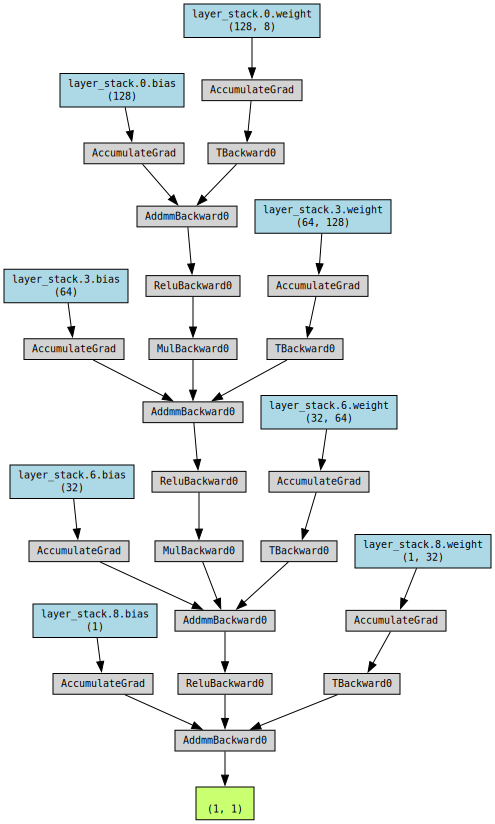

In [11]:
# Visualize Regression Model 2 Architecture
print("Visualizing Regression Model 2 Architecture...")
sample_input_reg = X_train_t_reg[0].unsqueeze(0) 

# Generate the graph
dot2 = make_dot(model2_reg(sample_input_reg), params=dict(model2_reg.named_parameters()))

# Display the graph in the notebook
display(dot2)

In [12]:
# Train and Evaluate Model 2
criterion_reg = nn.MSELoss()
optimizer_reg2 = optim.Adam(model2_reg.parameters(), lr=0.001)

epochs = 50
print("\nTraining Regression Model 2...")

for epoch in range(epochs):
    model2_reg.train() # Set model to training mode (activates dropout)
    for inputs, labels in train_loader_reg:
        outputs = model2_reg(inputs)
        loss = criterion_reg(outputs, labels)
        optimizer_reg2.zero_grad()
        loss.backward()
        optimizer_reg2.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate Model 2
print("Evaluating Model 2...")
model2_reg.eval() # Set model to eval mode (DEACTIVATES dropout)
with torch.no_grad():
    y_pred_reg2 = model2_reg(X_test_t_reg)
    mse = mean_squared_error(y_test_t_reg.numpy(), y_pred_reg2.numpy())
    print(f"Model 2 Test MSE: {mse:.4f}")


Training Regression Model 2...
Epoch [10/50], Loss: 0.4474
Epoch [20/50], Loss: 0.2809
Epoch [30/50], Loss: 0.1016
Epoch [40/50], Loss: 0.3027
Epoch [50/50], Loss: 0.2012
Training complete.
Evaluating Model 2...
Model 2 Test MSE: 0.2614


### 1.10: SHAP Interpretation (Regression)

Using the corrected `shap.DeepExplainer` approach.

In [13]:
# 1. Create the background dataset (a sample of the training data)
# We use the numpy array for shap.sample, then convert to tensor
background_data_reg_np = shap.sample(X_train_scaled_reg, 100)
background_data_reg_t = torch.tensor(background_data_reg_np, dtype=torch.float32)

print(f"Background tensor shape: {background_data_reg_t.shape}")

Background tensor shape: torch.Size([100, 8])


#### Model 1 SHAP Interpretation

In [14]:
# 2. Put model in eval mode
model1_reg.eval()

# 3. Initialize the SHAP DeepExplainer
explainer_reg1 = shap.DeepExplainer(model1_reg, background_data_reg_t)

# 4. Calculate SHAP values for the TEST set
print("Calculating SHAP values for Model 1...")
shap_values_reg1 = explainer_reg1.shap_values(X_test_t_reg)
print("Calculation complete.")

Calculating SHAP values for Model 1...
Calculation complete.


Model 1: Global Feature Importance


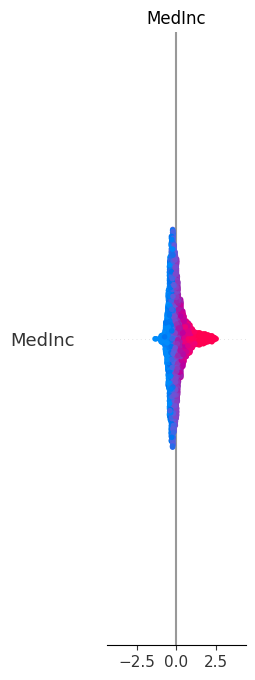

In [15]:
# Global feature importance (Summary Plot)
print("Model 1: Global Feature Importance")
shap.summary_plot(shap_values_reg1, X_test_scaled_reg, feature_names=features_reg)

Model 1: Local Interpretation for first prediction


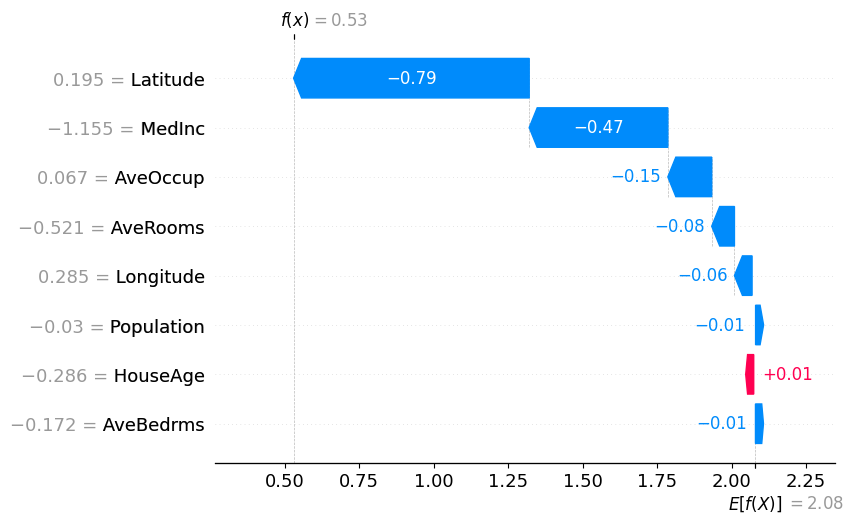

In [16]:
# Local interpretation (Waterfall Plot)
print("Model 1: Local Interpretation for first prediction")

# FIX: Create a shap.Explanation object for the waterfall plot
# We select the first sample [0] and .squeeze() the values to make them 1D (fixes ValueError)
exp = shap.Explanation(
    values=shap_values_reg1[0].squeeze(),
    base_values=explainer_reg1.expected_value[0],
    data=X_test_scaled_reg[0],
    feature_names=features_reg
)
shap.plots.waterfall(exp)

#### Model 2 SHAP Interpretation

In [17]:
# 1. Put model in eval mode
model2_reg.eval()

# 2. Initialize the SHAP Explainer
explainer_reg2 = shap.DeepExplainer(model2_reg, background_data_reg_t)

# 3. Calculate SHAP values
print("Calculating SHAP values for Model 2...")
shap_values_reg2 = explainer_reg2.shap_values(X_test_t_reg)
print("Calculation complete.")

Calculating SHAP values for Model 2...
Calculation complete.


Model 2: Global Feature Importance


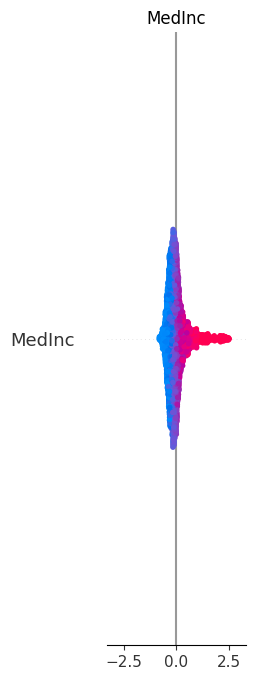

In [18]:
# Global feature importance (Summary Plot)
print("Model 2: Global Feature Importance")
shap.summary_plot(shap_values_reg2, X_test_scaled_reg, feature_names=features_reg)

Model 2: Local Interpretation for first prediction


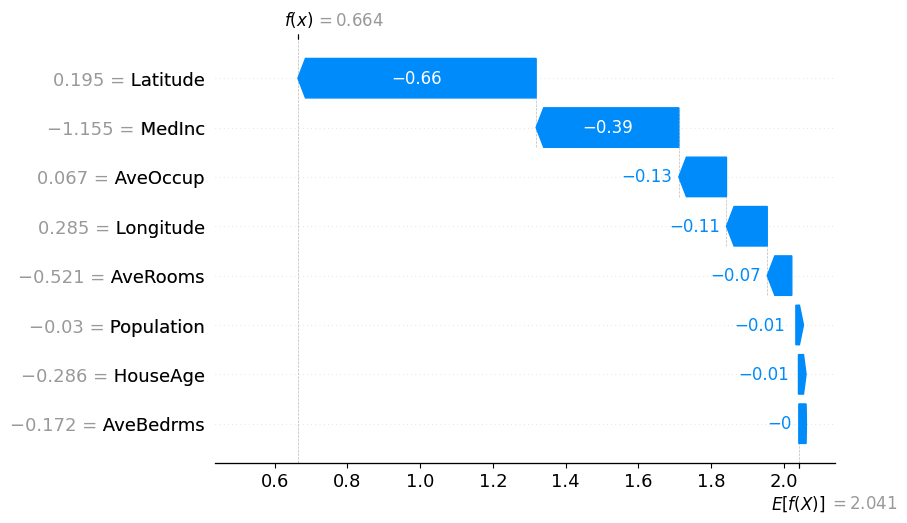

In [19]:
# Local interpretation (Waterfall Plot)
print("Model 2: Local Interpretation for first prediction")

# FIX: Create an Explanation object for the first sample
exp2 = shap.Explanation(
    values=shap_values_reg2[0].squeeze(),
    base_values=explainer_reg2.expected_value[0],
    data=X_test_scaled_reg[0],
    feature_names=features_reg
)
shap.plots.waterfall(exp2)

---

## MODULE 2: CLASSIFICATION

### 2.1: Load and Prepare Classification Data

We'll use the Breast Cancer dataset.

In [20]:
# Load sample data
cancer = load_breast_cancer()
data_class = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_class['Target'] = cancer.target

print("Classification Data Head:")
display(data_class.head())

Classification Data Head:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 2.2: Data Processing (Classification)


In [21]:
# 1. Define Target and Features
TARGET_COLUMN_CLASS = 'Target'
features_class = [col for col in data_class.columns if col != TARGET_COLUMN_CLASS]

X_class = data_class[features_class]
y_class = data_class[TARGET_COLUMN_CLASS]

# 2. Train-Test Split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

# 3. Scale the data
scaler_class = StandardScaler()
X_train_scaled_class = scaler_class.fit_transform(X_train_class)
X_test_scaled_class = scaler_class.transform(X_test_class)

print(f"Training data shape: {X_train_scaled_class.shape}")
print(f"Test data shape: {X_test_scaled_class.shape}")

Training data shape: (455, 30)
Test data shape: (114, 30)


### 2.3: Convert Data to PyTorch Tensors (Classification)

For binary classification with `nn.BCELoss` (Binary Cross-Entropy Loss), the target `y` tensor must also be `float32` and have the shape `[n_samples, 1]`.

In [22]:
# Convert numpy arrays to PyTorch tensors
X_train_t_class = torch.tensor(X_train_scaled_class, dtype=torch.float32)
y_train_t_class = torch.tensor(y_train_class.values, dtype=torch.float32).view(-1, 1)

X_test_t_class = torch.tensor(X_test_scaled_class, dtype=torch.float32)
y_test_t_class = torch.tensor(y_test_class.values, dtype=torch.float32).view(-1, 1)

# Create TensorDataset and DataLoader
train_dataset_class = TensorDataset(X_train_t_class, y_train_t_class)
train_loader_class = DataLoader(train_dataset_class, batch_size=32, shuffle=True)

print(f"Train tensor X shape: {X_train_t_class.shape}")
print(f"Train tensor y shape: {y_train_t_class.shape}")

Train tensor X shape: torch.Size([455, 30])
Train tensor y shape: torch.Size([455, 1])


### 2.4: Classification ANN - Model 1 (Simple Architecture)

The model ends with a `nn.Linear(..., 1)` layer followed by `nn.Sigmoid()` for binary classification.

In [23]:
class ClassificationModel1(nn.Module):
    def __init__(self, input_shape):
        super(ClassificationModel1, self).__init__()
        self.layer1 = nn.Linear(input_shape, 32)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.output(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
input_shape_class = X_train_t_class.shape[1]
model1_class = ClassificationModel1(input_shape_class)
print(model1_class)

ClassificationModel1(
  (layer1): Linear(in_features=30, out_features=32, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### 2.5: Visualize Classification Model 1 Architecture


Visualizing Classification Model 1 Architecture...


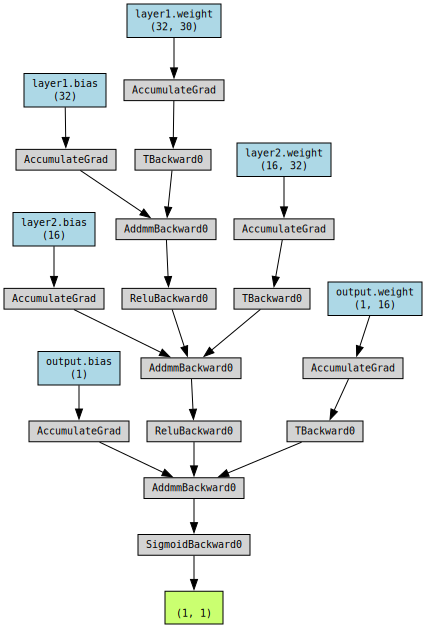

In [24]:
# Visualize Classification Model 1 Architecture
print("Visualizing Classification Model 1 Architecture...")
sample_input_class = X_train_t_class[0].unsqueeze(0) 

# Generate the graph
dot_class1 = make_dot(model1_class(sample_input_class), params=dict(model1_class.named_parameters()))

# Display the graph in the notebook
display(dot_class1)

### 2.6: Training & Evaluation (Model 1)

In [25]:
# Define loss function and optimizer
criterion_class = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer_class1 = optim.Adam(model1_class.parameters(), lr=0.001)

epochs = 50
print("Training Classification Model 1...")

for epoch in range(epochs):
    model1_class.train()
    for inputs, labels in train_loader_class:
        outputs = model1_class(inputs)
        loss = criterion_class(outputs, labels)
        
        optimizer_class1.zero_grad()
        loss.backward()
        optimizer_class1.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate Model 1
print("\nEvaluating Model 1...")
model1_class.eval()
with torch.no_grad():
    y_pred_probs = model1_class(X_test_t_class)
    # Convert probabilities to binary predictions (0 or 1)
    y_pred_class1 = (y_pred_probs > 0.5).int()
    
    acc = accuracy_score(y_test_t_class.numpy(), y_pred_class1.numpy())
    print(f"Model 1 Test Accuracy: {acc:.4f}")
    print(classification_report(y_test_t_class.numpy(), y_pred_class1.numpy()))

Training Classification Model 1...
Epoch [10/50], Loss: 0.0675
Epoch [20/50], Loss: 0.0169
Epoch [30/50], Loss: 0.0008
Epoch [40/50], Loss: 0.0221
Epoch [50/50], Loss: 0.0023
Training complete.

Evaluating Model 1...
Model 1 Test Accuracy: 0.9561
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94        42
         1.0       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



### 2.7: Classification ANN - Model 2 (Deeper w/ Dropout)

In [26]:
class ClassificationModel2(nn.Module):
    def __init__(self, input_shape):
        super(ClassificationModel2, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer_stack(x)

# Instantiate the model
model2_class = ClassificationModel2(input_shape_class)
print(model2_class)

ClassificationModel2(
  (layer_stack): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


### 2.8: Visualize Classification Model 2 Architecture


Visualizing Classification Model 2 Architecture...


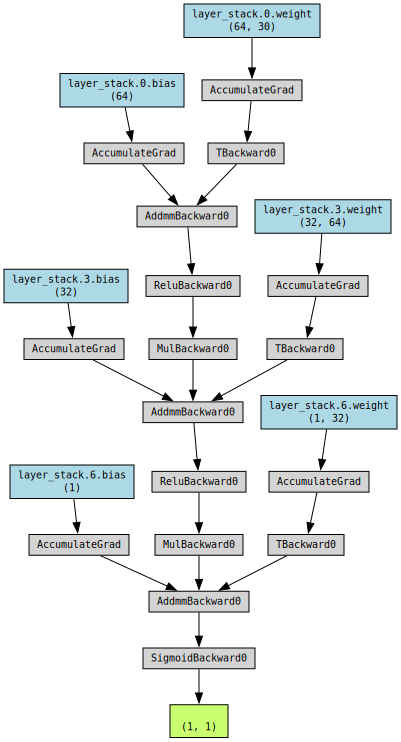

In [27]:
# Visualize Classification Model 2 Architecture
print("Visualizing Classification Model 2 Architecture...")
sample_input_class = X_train_t_class[0].unsqueeze(0) 

# Generate the graph
dot_class2 = make_dot(model2_class(sample_input_class), params=dict(model2_class.named_parameters()))

# Display the graph in the notebook
display(dot_class2)

In [28]:
# Train and Evaluate Model 2
criterion_class = nn.BCELoss()
optimizer_class2 = optim.Adam(model2_class.parameters(), lr=0.001)

epochs = 50
print("\nTraining Classification Model 2...")

for epoch in range(epochs):
    model2_class.train()
    for inputs, labels in train_loader_class:
        outputs = model2_class(inputs)
        loss = criterion_class(outputs, labels)
        optimizer_class2.zero_grad()
        loss.backward()
        optimizer_class2.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate Model 2
print("\nEvaluating Model 2...")
model2_class.eval()
with torch.no_grad():
    y_pred_probs = model2_class(X_test_t_class)
    y_pred_class2 = (y_pred_probs > 0.5).int()
    
    acc = accuracy_score(y_test_t_class.numpy(), y_pred_class2.numpy())
    print(f"Model 2 Test Accuracy: {acc:.4f}")
    print(classification_report(y_test_t_class.numpy(), y_pred_class2.numpy()))


Training Classification Model 2...
Epoch [10/50], Loss: 0.0774
Epoch [20/50], Loss: 0.0179
Epoch [30/50], Loss: 0.5497
Epoch [40/50], Loss: 0.0424
Epoch [50/50], Loss: 0.0032
Training complete.

Evaluating Model 2...
Model 2 Test Accuracy: 0.9561
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94        42
         1.0       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



### 2.9: SHAP Interpretation (Classification)

The SHAP code for classification has been vetted and uses the correct `DeepExplainer` and `.squeeze()` methods to ensure visualization works correctly.

In [29]:
# 1. Create the background dataset (a sample of the training data)
background_data_class_np = shap.sample(X_train_scaled_class, 100)
background_data_class_t = torch.tensor(background_data_class_np, dtype=torch.float32)

print(f"Background tensor shape: {background_data_class_t.shape}")

Background tensor shape: torch.Size([100, 30])


#### Model 1 SHAP Interpretation

In [30]:
# 2. Put model in eval mode
model1_class.eval()

# 3. Initialize the SHAP Explainer
explainer_class1 = shap.DeepExplainer(model1_class, background_data_class_t)

# 4. Calculate SHAP values for the TEST set
print("Calculating SHAP values for Model 1...")

# FIX: Use .squeeze() to remove all singleton dimensions, then use 
# np.atleast_2d() to ensure the result is a 2D matrix, fixing the AssertionError.
raw_shap_values = explainer_class1.shap_values(X_test_t_class)[0].squeeze()
shap_values_class1 = np.atleast_2d(raw_shap_values)

print("Calculation complete.")

Calculating SHAP values for Model 1...
Calculation complete.


Model 1: Global Feature Importance


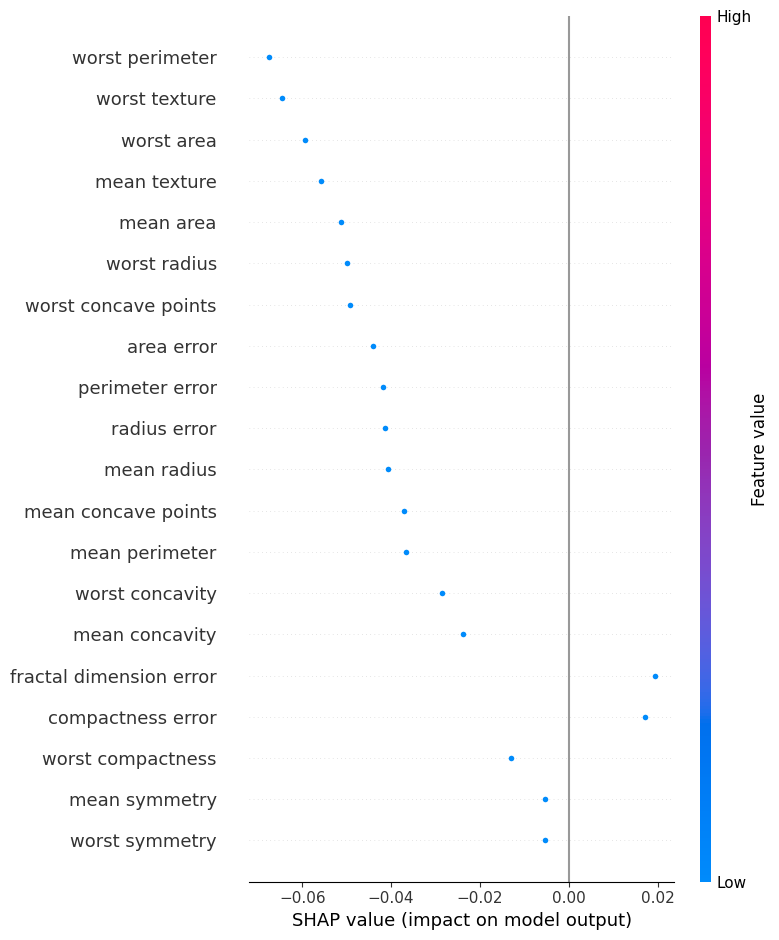

In [31]:
# Global feature importance (Summary Plot)
print("Model 1: Global Feature Importance")

# FIX: Get the exact number of rows from the calculated SHAP matrix
n_rows_shap = shap_values_class1.shape[0]

# Slice the feature matrix (X_test_scaled_class) to match the SHAP matrix size
features_for_plot = X_test_scaled_class[:n_rows_shap]

# Plot with the sliced features
shap.summary_plot(shap_values_class1, features_for_plot, feature_names=features_class)

Model 1: Local Interpretation for first prediction


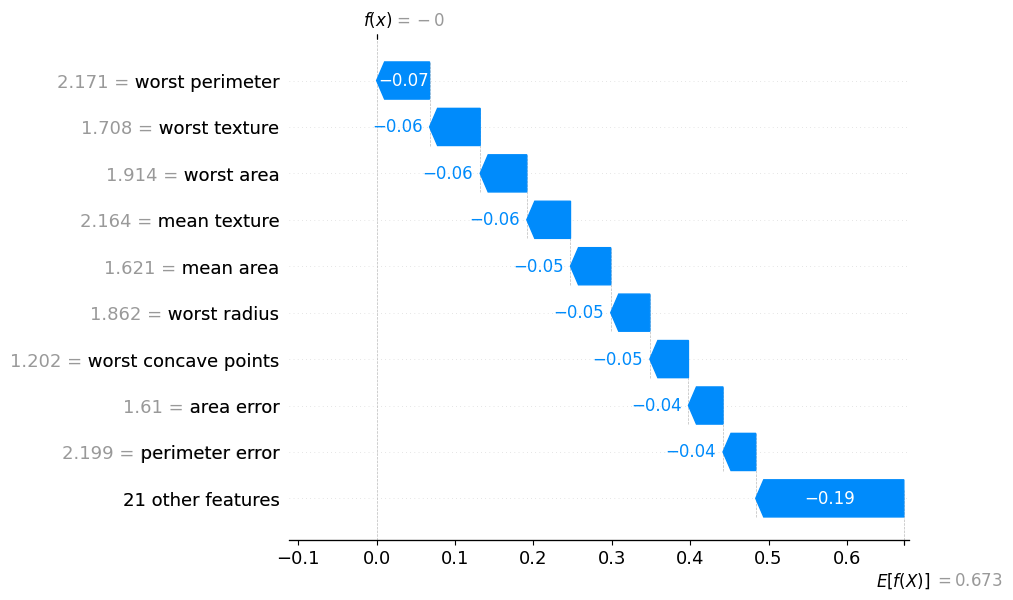

In [32]:
# Local interpretation (Waterfall Plot)
print("Model 1: Local Interpretation for first prediction")

# FIX: Remove .squeeze() here, as the main array was squeezed in the calculation step.
exp_class1 = shap.Explanation(
    values=shap_values_class1[0], # Just select the first sample, which is now 1D
    base_values=explainer_class1.expected_value[0],
    data=X_test_scaled_class[0],
    feature_names=features_class
)
shap.plots.waterfall(exp_class1)

#### Model 2 SHAP Interpretation

In [33]:
# 2. Put model in eval mode
model1_class.eval()

# 3. Initialize the SHAP Explainer
explainer_class2 = shap.DeepExplainer(model2_class, background_data_class_t)

# 4. Calculate SHAP values for the TEST set
print("Calculating SHAP values for Model 2...")

# FIX: Use .squeeze() to remove all singleton dimensions, then use 
# np.atleast_2d() to ensure the result is a 2D matrix, fixing the AssertionError.
raw_shap_values = explainer_class2.shap_values(X_test_t_class)[0].squeeze()
shap_values_class2 = np.atleast_2d(raw_shap_values)

print("Calculation complete.")

Calculating SHAP values for Model 2...
Calculation complete.


Model 2: Global Feature Importance


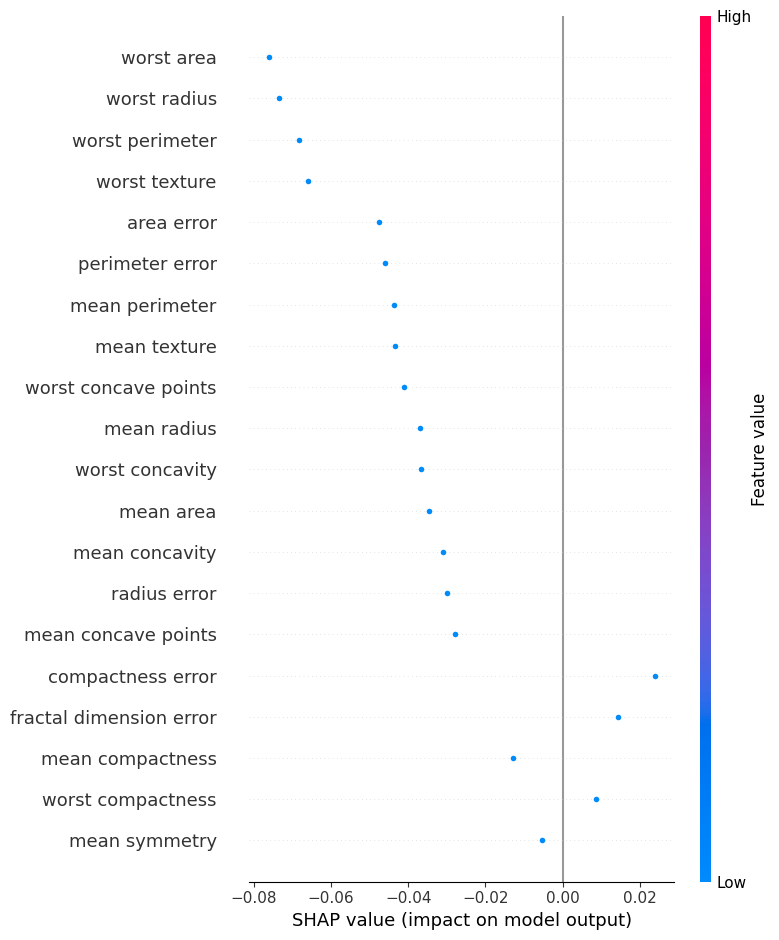

In [34]:
 # Global feature importance (Summary Plot)
print("Model 2: Global Feature Importance")

# FIX: Get the exact number of rows from the calculated SHAP matrix
n_rows_shap = shap_values_class2.shape[0]

# Slice the feature matrix (X_test_scaled_class) to match the SHAP matrix size
features_for_plot = X_test_scaled_class[:n_rows_shap]

# Plot with the sliced features
shap.summary_plot(shap_values_class2, features_for_plot, feature_names=features_class)

Model 2: Local Interpretation for first prediction


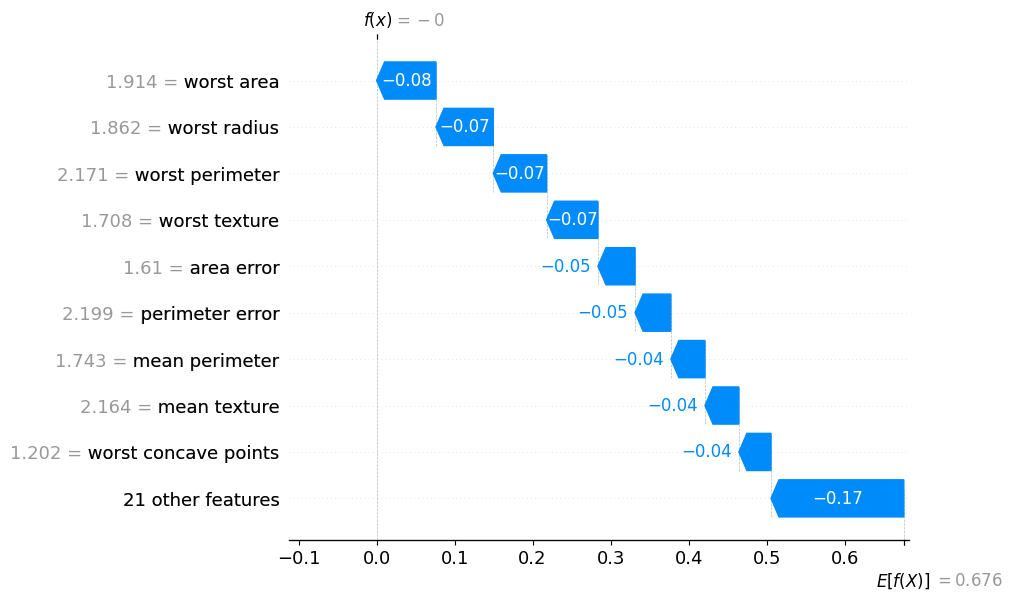

In [35]:
# Local interpretation (Waterfall Plot)
print("Model 2: Local Interpretation for first prediction")

# FIX: Remove .squeeze() here.
exp_class2 = shap.Explanation(
    values=shap_values_class2[0], # Just select the first sample, which is now 1D
    base_values=explainer_class2.expected_value[0],
    data=X_test_scaled_class[0],
    feature_names=features_class
)
shap.plots.waterfall(exp_class2)

---

## 💡 How to Read the Waterfall Plot (For Your Project)

This plot is the *most important* part for showing a new learner how a single prediction is made. It directly addresses **"how its making the prediction"**.

Here is a simple way to explain it:

1.  **Starts at the Bottom (`E[f(X)]`):** The plot starts with the **base value**. This is the average prediction the model would make if it knew nothing about the current data point (it's the average of all training predictions).

2.  **Builds Up with Features:** Each row above the base is one of your data's features (like 'mean radius' or 'MedInc').
    * **<span style='color:red;'>Red bars (Positive)</span>** are features that **pushed** the prediction **higher** (for regression) or **towards Class 1** (for classification).
    * **<span style='color:blue;'>Blue bars (Negative)</span>** are features that **pushed** the prediction **lower** (for regression) or **towards Class 0** (for classification).
    * The **length** of the bar shows *how much* impact that feature had.

3.  **Ends at the Top (`f(x)`):** After adding up all the feature contributions, you arrive at the **final prediction** at the top. 

> The plot *walks you through* the model's 'thought process', starting from an average guess and adding/subtracting evidence from each feature to arrive at the final answer for *one specific row of data*.

## Conclusion & Key Takeaways

This notebook provides the complete PyTorch workflow for interpreting ANN models on tabular data.

**Key Takeaways for your Project:**

1.  **`torchviz`:** We now have diagrams for *all* models, which is excellent for visualizing the ANN structure.
2.  **SHAP Fixes:** The use of `shap.DeepExplainer` combined with **`.squeeze()`** ensures the waterfall plots render correctly for both regression and classification, providing reliable local interpretability.
3.  **PyTorch Discipline:** Always remember to use `model.train()` for training and `model.eval()` for testing and SHAP interpretation.